# Summary

## In this project, we review the paper [A Trainable Optimal Transport Embedding for Feature Aggregation and its Relationship to Attention](https://openreview.net/pdf?id=ZK6vTvb84s) written by Mialon et al.

## We will study the quality of the approximated 2-Wasserstein distance $W_2^z$ for a given random reference z with uniform weights on 1D distribution and 2D point clouds.

## We will design a 2-Wasserstein GAN [[Arkojvski, 2017]](https://arxiv.org/pdf/1701.07875.pdf) and adapt it using the approximation $W_2^z$.

## We will perform a logistic classification on the MNIST dataset using the OTK embeddings implemented in [GregoireMialon/OTK](https://github.com/GregoireMialon/OTK/tree/9c414d800476df2ad84fcf8042e717eb992e3370).

# Acknowledgement
## We reuse parts of code implemented in [Peyré Numerics Tours](https://nbviewer.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_1_linprog.ipynb), [POT 1D](https://pythonot.github.io/auto_examples/plot_OT_1D.html#sphx-glr-auto-examples-plot-ot-1d-py), [WGAN](https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py) and [sklearn_MNIST](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html).

# Import

In [ ]:
!pip install POT

import time
import os

import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

import numpy as np
import matplotlib.pylab as pl
from matplotlib.lines import Line2D

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')
path_project = "MVA/Courses/Optimal_Transport/Project"
os.chdir("/content/drive/MyDrive/"+path_project)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
SEED = 3407
np.random.seed(SEED)

## You should create a folder "figures/" to save figures

# 1. Wasserstein Distance Approximation with 1D distributions

## Generate Data

In [ ]:
n = 100  # nb bins
m = 80 # nb bins
p = 50

# Bin positions
x = np.arange(n, dtype=np.float64)
y = np.arange(m, dtype=np.float64)
z = np.random.rand(p) 

# Weights
a = gauss(n, m=30, s=10) 
b = gauss(m, m=15, s=5)
c = np.ones((p,)) / p 

## Plot distributions



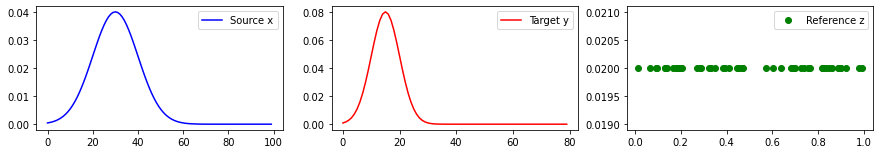

In [ ]:
pl.figure(1, figsize=(15, 5))
pl.subplot(2, 3, 1)
pl.plot(x, a, 'b', label='Source x')
pl.legend()
pl.subplot(2, 3, 2)
pl.plot(y, b, 'r', label='Target y')
pl.legend()
pl.subplot(2, 3, 3)
pl.plot(z, c, 'o', color='g', label='Reference z')
pl.legend()
pl.savefig('figures/1D_data_distributions.png')
pl.show()

## Compute and plot cost matrices
Compute the cost matrix $M_{i,j} := ||x_i-x_j||^2$.

In [ ]:
M_xy = ot.dist(x.reshape((n, 1)),y.reshape((m, 1)), metric='euclidean') ** 2
M_xz = ot.dist(x.reshape((n, 1)), z.reshape((p, 1)), metric='euclidean') ** 2
M_yz = ot.dist(y.reshape((m, 1)), z.reshape((p, 1)), metric='euclidean') ** 2

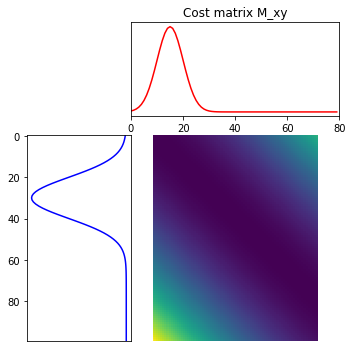

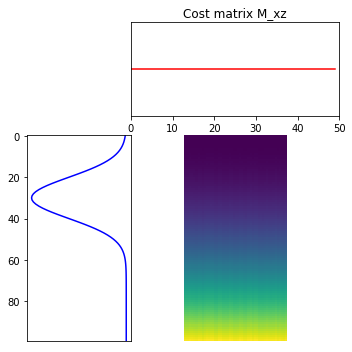

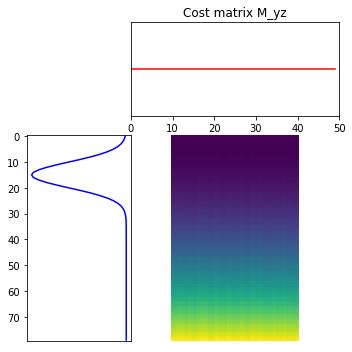

In [ ]:
pl.figure(1, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M_xy, 'Cost matrix M_xy')
pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, c, M_xz, 'Cost matrix M_xz')
pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(b, c, M_yz, 'Cost matrix M_yz')

## Solve EMD

In [ ]:
# EMD
P_xy = ot.emd(a, b, M_xy)
P_xz = ot.emd(a, c, M_xz)
P_yz = ot.emd(b, c, M_yz)

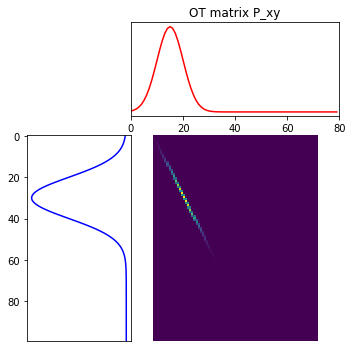

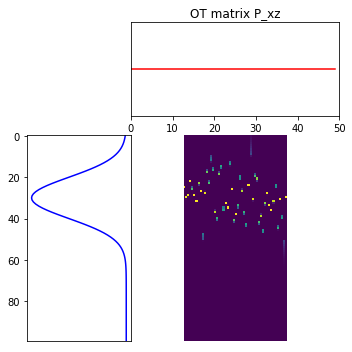

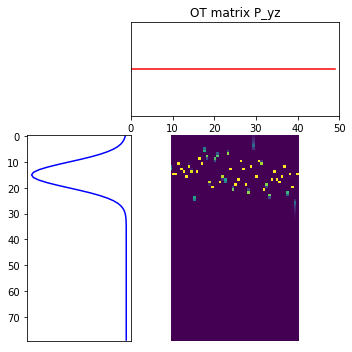

In [ ]:
pl.figure(1, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, P_xy, 'OT matrix P_xy')
pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, c, P_xz, 'OT matrix P_xz')
pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(b, c, P_yz, 'OT matrix P_yz')

## Compute approximated matching $P_z$

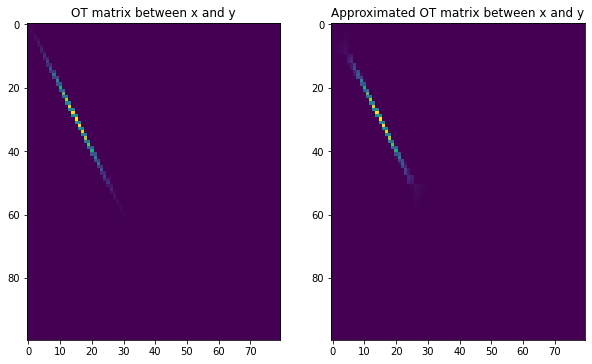

In [ ]:
P_approx = p * P_xz @ P_yz.T 

pl.figure(2, figsize=(10, 10))
pl.subplot(1, 2, 1)
pl.imshow(P_xy, interpolation='nearest')
pl.title('OT matrix between x and y')
pl.subplot(1, 2, 2)
pl.imshow(P_approx, interpolation='nearest')
pl.title('Approximated OT matrix between x and y')
pl.savefig('figures/1D_wasserstein_approx.png')
pl.show()

## Evaluate Wasserstein approximation

In [ ]:
min_dist = lambda x,y: min(x,y)

def wasserstein_error(n, m, p, x, y, a, b):
  """ 
  Function to evaluate of wasserstein approximation
  between distribution x and y
  """

  # bin positions
  z = np.random.randn(p) 

  # Uniform weights: proof of the bound on the error requires to have uniform weights
  c = np.ones((p,)) / p 

  # Compute cost matrices
  M_xy = ot.dist(x.reshape((n, 1)),y.reshape((m, 1)), metric='euclidean') ** 2
  M_xz = ot.dist(x.reshape((n, 1)), z.reshape((p, 1)), metric='euclidean') ** 2
  M_yz = ot.dist(y.reshape((m, 1)), z.reshape((p, 1)), metric='euclidean') ** 2
 
  # # Compute optimal matching with EMD
  P_xy = ot.emd(a, b, M_xy)
  P_xz = ot.emd(a, c, M_xz)
  P_yz = ot.emd(b, c, M_yz)

  # Compute 2-wasserstein distances
  W2_xy = np.trace(P_xy.T @ M_xy) ** (1/2)
  W2_xz = np.trace(P_xz.T @ M_xz) ** (1/2)
  W2_yz = np.trace(P_yz.T @ M_yz) ** (1/2)

  bound = 2 * min_dist(W2_xz, W2_yz)

  # Compute approximated wasserstein distance
  P_approx = p * P_xz @ P_yz.T
  W2_approx = np.trace(P_approx.T @ M_xy) ** (1/2)

  # Compute error
  error = np.abs(W2_xy - W2_approx)
  
  return error, bound

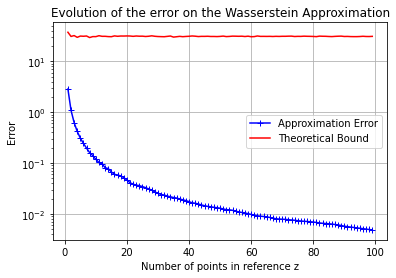

In [ ]:
n = 100  # nb bins
m = 80 # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)
y = np.arange(m, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=30, s=10) 
b = gauss(m, m=15, s=5)

errors = []
bounds = []
n_points = range(1,100)
for p in n_points:
  error, bound = wasserstein_error(n, m, p, x, y, a, b)
  errors.append(error)
  bounds.append(bound)

pl.figure(1)
pl.grid()
pl.semilogy(n_points, errors, '-+', color='b', label="Approximation Error")
pl.semilogy(n_points, bounds, color='r', label="Theoretical Bound")
pl.title('Evolution of the error on the Wasserstein Approximation')
pl.xlabel('Number of points in reference z')
pl.ylabel('Error')
pl.legend(loc='middle right')
pl.savefig('figures/1D_wasserstein_approx_eval.png')
pl.show()

## We showed empirically that $W_2^z(x,y) \leq 2 \min \{W_2(x,z), W_2(y,z)\}$.

# 2. Wasserstein distance approximation with 2D point clouds

## Generate point clouds

In [ ]:
normalize = lambda u: u/np.sum(u)
gaussian = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))

n = 100 
m = 80
p = 50 

# Bins positions
X = np.random.randn(n,2)*.1
Y = np.hstack((gaussian(int(m/2),.2,[0,1.6]),np.hstack((gaussian(int(m/4),.1,[-1,-1]),gaussian(int(m/4),.1,[1,-1])))))
Y = Y.T
theta = 2*np.pi*np.random.rand(1,p)
r = .6 + .2*np.random.rand(1,p)
Z = np.vstack((np.cos(theta)*r,np.sin(theta)*r)) # points inside an annulus
Z = Z.T

# Weights
a = normalize(np.random.rand(n,))
b = normalize(np.random.rand(m,))
c = np.ones((p,)) / p 

## Plot distributions



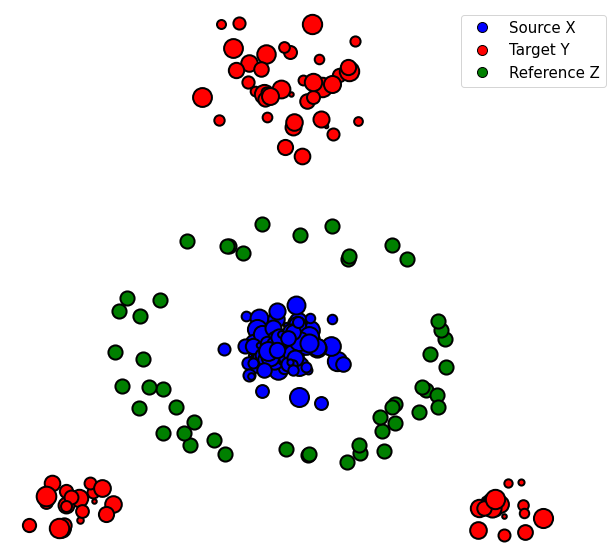

In [ ]:
myplot = lambda x,y,ms,col: pl.scatter(x, y, s=ms*20, edgecolors="k", c=col, linewidths=2)

custom = [Line2D([], [], marker='.', markersize=20, color='b', linestyle='None', markeredgecolor='k'),
          Line2D([], [], marker='.', markersize=20, color='r', linestyle='None', markeredgecolor='k'),
          Line2D([], [], marker='.', markersize=20, color='g', linestyle='None', markeredgecolor='k')]

pl.figure(figsize = (10,10))
pl.axis("off")
for i in range(len(a)):
    scatter = myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
for k in range(len(c)):
    myplot(Z[k,0], Z[k,1], c[k]*len(c)*10, 'g')

pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.legend(custom, ['Source X', 'Target Y', 'Reference Z'], loc='upper left', fontsize=15, bbox_to_anchor=(0.8, 1))
pl.savefig('figures/2D_data_distributions.png')
pl.show()

## Compute and plot cost matrices

In [ ]:
# loss matrix
M_XY = ot.dist(X, Y, metric='euclidean') ** 2
M_XZ = ot.dist(X, Z, metric='euclidean') ** 2
M_YZ = ot.dist(Y, Z, metric='euclidean') ** 2

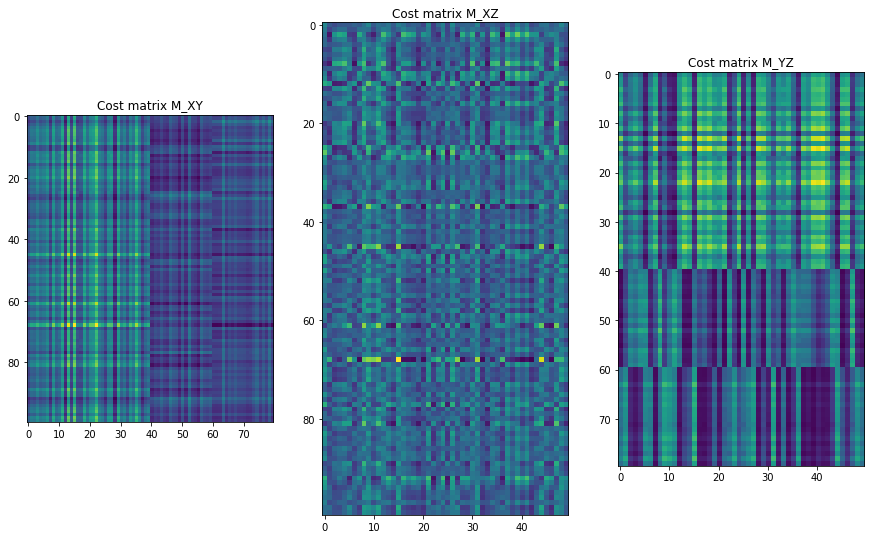

In [ ]:
pl.figure(2, figsize=(15, 10))
pl.subplot(1, 3, 1)
pl.imshow(M_XY, interpolation='nearest')
pl.title('Cost matrix M_XY')
pl.subplot(1, 3, 2)
pl.imshow(M_XZ, interpolation='nearest')
pl.title('Cost matrix M_XZ')
pl.subplot(1, 3, 3)
pl.imshow(M_YZ, interpolation='nearest')
pl.title('Cost matrix M_YZ')
pl.show()

## Solve EMD

In [ ]:
# EMD
P_XY = ot.emd(a, b, M_XY)
P_XZ = ot.emd(a, c, M_XZ)
P_YZ = ot.emd(b, c, M_YZ)

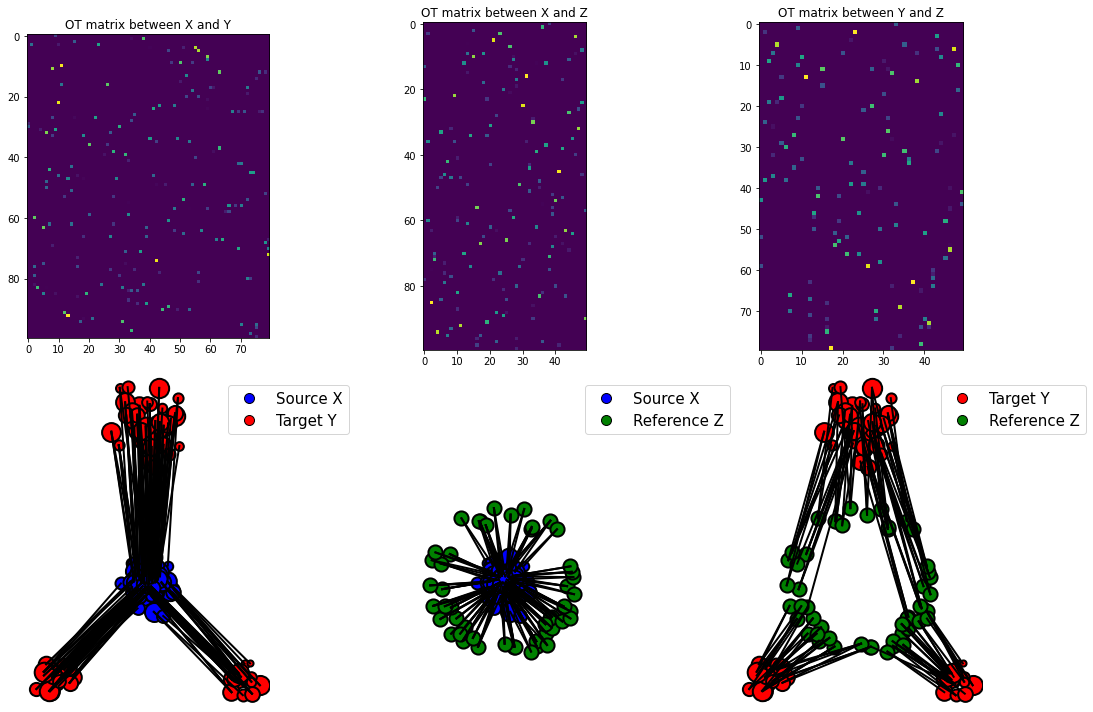

In [ ]:
custom = [Line2D([], [], marker='.', markersize=20, color='b', linestyle='None', markeredgecolor='k'),
          Line2D([], [], marker='.', markersize=20, color='r', linestyle='None', markeredgecolor='k'),
          Line2D([], [], marker='.', markersize=20, color='g', linestyle='None', markeredgecolor='k')]

custom_bis = [Line2D([], [], marker='.', markersize=20, color='b', linestyle='None', markeredgecolor='k'),
          Line2D([], [], marker='.', markersize=20, color='g', linestyle='None', markeredgecolor='k')]

pl.figure(2, figsize=(15, 10))
pl.title('test')
pl.subplot(2, 3, 1)
pl.imshow(P_XY, interpolation='nearest')
pl.title('OT matrix between X and Y')

pl.subplot(2, 3, 2)
pl.imshow(P_XZ, interpolation='nearest')
pl.title('OT matrix between X and Z')

pl.subplot(2, 3, 3)
pl.imshow(P_YZ, interpolation='nearest')
pl.title('OT matrix between Y and Z')

pl.subplot(2, 3, 4)
pl.axis("off")
I,J = np.nonzero(P_XY>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.legend(custom[:-1], ['Source X', 'Target Y'], loc='upper left', fontsize=15, bbox_to_anchor=(0.8, 1))

pl.subplot(2, 3, 5)
pl.axis("off")
I,J = np.nonzero(P_XZ>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Z[J[k],0])),np.hstack(([X[I[k],1], Z[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(c)):
    myplot(Z[j,0], Z[j,1], c[j]*len(c)*10, 'g')
pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.legend(custom_bis, ['Source X', 'Reference Z'], loc='upper left', fontsize=15, bbox_to_anchor=(0.8, 1))

pl.subplot(2, 3, 6)
pl.axis("off")
I,J = np.nonzero(P_YZ>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((Y[I[k],0],Z[J[k],0])),np.hstack(([Y[I[k],1], Z[J[k],1]])),'k', lw = 2)
for i in range(len(b)):
    myplot(Y[i,0], Y[i,1], b[i]*len(b)*10, 'r')
for j in range(len(c)):
    myplot(Z[j,0], Z[j,1], c[j]*len(c)*10, 'g')
pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.legend(custom[1:], ['Target Y', 'Reference Z'], loc='upper left', fontsize=15, bbox_to_anchor=(0.8, 1))

pl.tight_layout()
pl.show()

## Compute approximated matching $P_z$

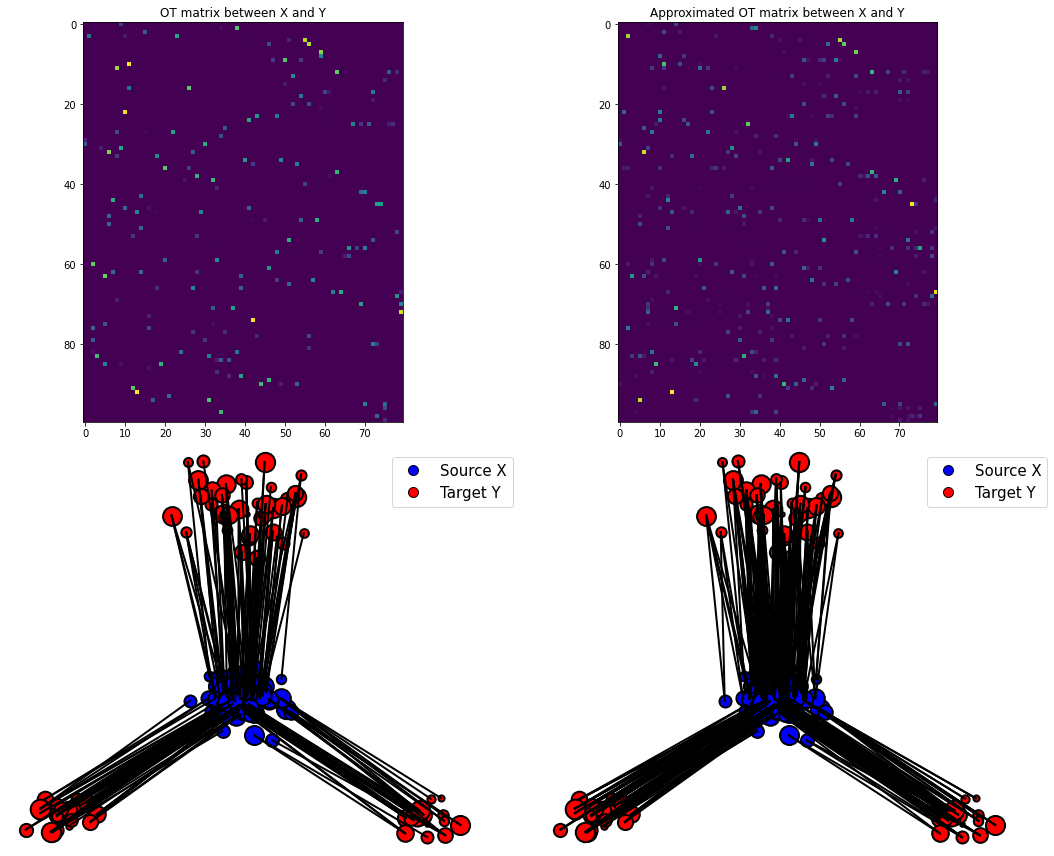

In [ ]:
P_approx = p * P_XZ @ P_YZ.T  

custom = [Line2D([], [], marker='.', markersize=20, color='b', linestyle='None', markeredgecolor='k'),
          Line2D([], [], marker='.', markersize=20, color='r', linestyle='None', markeredgecolor='k')]

pl.figure(2, figsize=(15, 12))

pl.subplot(2, 2, 1)
pl.imshow(P_XY, interpolation='nearest')
pl.title('OT matrix between X and Y')

pl.subplot(2, 2, 2)
pl.imshow(P_approx, interpolation='nearest')
pl.title('Approximated OT matrix between X and Y')

pl.subplot(2, 2, 3)
pl.axis("off")
I,J = np.nonzero(P_XY>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.legend(custom, ['Source X', 'Target Y'], loc='upper left', fontsize=15, bbox_to_anchor=(0.8, 1))

pl.subplot(2, 2, 4)
pl.axis("off")
I,J = np.nonzero(P_approx>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.legend(custom, ['Source X', 'Target Y'], loc='upper left', fontsize=15, bbox_to_anchor=(0.8, 1))

pl.savefig('figures/2D_wasserstein_approx.png')
pl.tight_layout()
pl.show()

In [ ]:
min_dist = lambda x,y: min(x,y)

def wasserstein_2D_error(n, m, p, X, Y, a, b):
  """ 
  Function to evaluate of wasserstein approximation
  between distribution x and y
  """

  # bin positions
  theta = 2*np.pi*np.random.rand(1,p)
  r = .6 + .2*np.random.rand(1,p)
  Z = np.vstack((np.cos(theta)*r,np.sin(theta)*r)) # red points inside an anulus
  Z = Z.T

  # Weights
  c = np.ones((p,)) / p 

  # Compute cost matrices
  M_XY = ot.dist(X, Y, metric='euclidean') ** 2
  M_XZ = ot.dist(X, Z, metric='euclidean') ** 2
  M_YZ = ot.dist(Y, Z, metric='euclidean') ** 2

  # # Compute optimal matching with EMD
  P_XY = ot.emd(a, b, M_XY)
  P_XZ = ot.emd(a, c, M_XZ)
  P_YZ = ot.emd(b, c, M_YZ)

  # Compute 2-wasserstein distances
  W2_XY = np.trace(P_XY.T @ M_XY) ** (1/2)
  W2_XZ = np.trace(P_XZ.T @ M_XZ) ** (1/2)
  W2_YZ = np.trace(P_YZ.T @ M_YZ) ** (1/2)

  bound = 2 * min_dist(W2_XZ, W2_YZ)

  # Compute approximated wasserstein distance
  P_approx = p * P_XZ @ P_YZ.T  
  W2_approx = np.trace(P_approx.T @ M_XY) ** (1/2)

  # Compute error
  error = np.abs(W2_XY - W2_approx)
  
  return error, bound

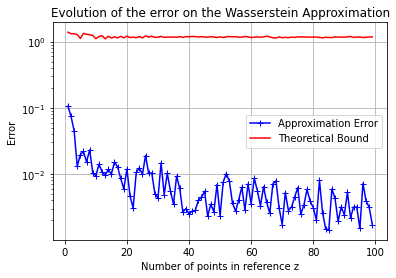

In [ ]:
n = 100
m = 80

X = np.random.randn(n,2)*.1
Y = np.hstack((gaussian(int(m/2),.2,[0,1.6]),np.hstack((gaussian(int(m/4),.1,[-1,-1]),gaussian(int(m/4),.1,[1,-1])))))
Y = Y.T

# Weights
a = normalize(np.random.rand(n,))
b = normalize(np.random.rand(m,))

errors = []
bounds = []
n_points = range(1,100)
for p in n_points:
  error, bound = wasserstein_2D_error(n, m, p, X, Y, a, b)
  errors.append(error)
  bounds.append(bound)

pl.figure(1)
pl.grid()
pl.semilogy(n_points, errors, '-+', color='b', label="Approximation Error")
pl.semilogy(n_points, bounds, color='r', label="Theoretical Bound")
pl.xlabel('Number of points in reference z')
pl.ylabel('Error')
pl.title('Evolution of the error on the Wasserstein Approximation')
pl.legend(loc='middle right')
pl.savefig('figures/2D_wasserstein_approx_eval.png')
pl.show()

## We showed empirically that $W_2^z(x,y) \leq 2 \min \{W_2(x,z), W_2(y,z)\}$.


# Wasserstein GAN

In this example inspired from [POT Wasserstein GAN](https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py), we train a Wasserstein GAN using 1-Wasserstein on minibatches
as a distribution fitting term.

We want to train a generator $G_\theta$ that generates realistic
data from random noise drawn from a Gaussian $\mu_n$ distribution so
that the data is indistinguishable from true data in the data distribution
$\mu_d$. To this end, Wasserstein GAN aims at optimizing
the parameters $\theta$ of the generator with the following
optimization problem:

\begin{align}\min_{\theta} W_1(\mu_d, G_\theta\#\mu_n)\end{align}

We will compare vanilla Wasserstein GAN with a GAN where the Wasserstein Distance $W_1(\textbf{x},\textbf{y})$ is approximated by $W_1^{\textbf{z}}(\textbf{x},\textbf{y}) = \langle \textbf{P}_{\textbf{z}}(\textbf{x},\textbf{y}),d_{\kappa}(\textbf{x},\textbf{y}) \rangle$ with $z$ a reference of $p$ points(inspired from [[Mialon, 2021]](https://openreview.net/pdf?id=ZK6vTvb84s) which proposes $W_2^{\textbf{z}}(\textbf{x},\textbf{y}) = \sqrt{\langle \textbf{P}_{\textbf{z}}(\textbf{x},\textbf{y}),d_{\kappa}^2(\textbf{x},\textbf{y}) \rangle}$ as an approximation of $W_2(\textbf{x},\textbf{y})$).

We will evaluate the quality of the approximation when p evolves.

## Data generation



In [ ]:
sigma = 0.1
n_dims = 2
n_features = 2

def get_data(n_samples):
    c = torch.rand(size=(n_samples, 1))
    angle = c * 2 * np.pi
    x = torch.cat((torch.cos(angle), torch.sin(angle)), 1)
    x += torch.randn(n_samples, 2) * sigma
    return x

def get_random(m_samples):
  y = torch.randn(m_samples,2)
  return y

def get_reference(p, r=.4):
    theta = 2*np.pi*np.random.rand(1,p)
    r = r + .2*np.random.rand(1,p)
    z = np.vstack((np.cos(theta)*r,np.sin(theta)*r)) # points inside an annulus
    return torch.Tensor(z.T)

## Plot data and reference



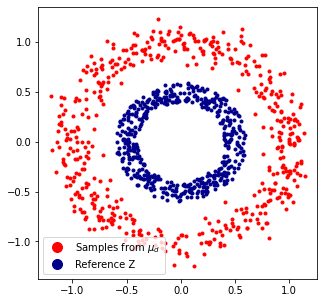

In [ ]:
# plot the distributions
marker = '.'
refcol = 'darkblue'
custom = [Line2D([], [], marker='.', markersize=20, color='r', linestyle='None'),
          Line2D([], [], marker='.', markersize=20, color=refcol, linestyle='None')]

n_samples = 500
X = get_data(n_samples)
p = 500
Z = get_reference(p)
pl.figure(1, (5,5))
pl.scatter(X[:, 0], X[:, 1], c='r', marker=marker)
pl.scatter(Z[:, 0], Z[:, 1], c=refcol, marker=marker)
pl.legend(custom, ['Samples from $\mu_d$', 'Reference Z'], loc='lower left')
pl.savefig('figures/WGAN_data_distribution.png')
pl.show()

## Generator Model



In [ ]:
# define the MLP model
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(n_features, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, n_dims)
        self.relu = torch.nn.ReLU()  # instead of Heaviside step fn

    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)  # instead of Heaviside step fn
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)
        return output

## Training the model



In [ ]:
def WGAN():

    G = Generator()
    optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

    # number of iteration and size of the batches
    n_iter = 200  
    size_batch = 500

    # generate statis samples to see their trajectory along training
    n_visu = 100
    xnvisu = get_random(n_visu) 
    xvisu = torch.zeros(n_iter, n_visu, n_dims)

    ab = torch.ones(size_batch) / size_batch
    losses = []

    for i in range(n_iter):

        # generate noise samples
        xn = get_random(size_batch) 

        # generate data samples
        xd = get_data(size_batch)

        # generate sample along iterations
        xvisu[i, :, :] = G(xnvisu).detach()

        # generate samples and compute distance matrix
        xg = G(xn)

        # wasserstein loss
        M = ot.dist(xg, xd)
        loss = ot.emd2(ab, ab, M)
        losses.append(float(loss.detach()))

        # optimization
        loss.backward()
        optimizer.step()

        del M

    return losses, G, xvisu, xd

def WGAN_approx(p):

    G = Generator()
    optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

    # number of iteration and size of the batches
    n_iter = 200  
    size_batch = 500

    # generate statis samples to see their trajectory along training
    n_visu = 100
    xnvisu = get_random(n_visu) 
    xvisu = torch.zeros(n_iter, n_visu, n_dims)

    ab = torch.ones(size_batch) / size_batch
    losses = []

    # Get reference
    z = get_reference(p)
    c = torch.ones((p,)) / p

    for i in range(n_iter):

        # generate noise samples
        xn = get_random(size_batch) #torch.randn(size_batch, n_features)

        # generate data samples
        xd = get_data(size_batch)

        # generate sample along iterations
        xvisu[i, :, :] = G(xnvisu).detach()

        # generate samples and compute distance matrix
        xg = G(xn)

        # loss matrices
        M = ot.dist(xg, xd)
        M_xg_z = ot.dist(xg, z)
        M_xd_z = ot.dist(xd, z)

        # optimal matching
        P = ot.emd(ab, ab, M)
        P_xg_z = ot.emd(ab, c, M_xg_z)
        P_xd_z = ot.emd(ab, c, M_xd_z)

        # approximated wasserstein loss
        P_approx = p * P_xg_z @ P_xd_z.T  
        loss = torch.trace(torch.mm(P_approx.T,M)) 
        losses.append(float(loss.detach()))

        # optimization
        loss.backward()
        optimizer.step()

        del M

    return losses, G, xvisu, xd

In [ ]:
marker = '.'

def plot_losses(losses, color=None):
    pl.semilogy(losses, color=color)
    pl.grid()
    pl.title('Wasserstein distance-based Training Loss')
    pl.xlabel("Number of iterations")
    pl.ylabel("Loss")
    pl.show()

def plot_trajectories(xd, xvisu, title=None):
    pl.figure(3, (10, 10))

    ivisu = [0, 10, 25, 50, 75, 125, 15, 175, 199]

    for i in range(9):
        pl.subplot(3, 3, i + 1)
        pl.axis("off")
        pl.scatter(xd[:, 0], xd[:, 1], marker=marker, c='r', label='Data samples from $\mu_d$')
        pl.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], marker=marker, c='black', label='Data samples from $G\#\mu_n$')
        pl.xticks(())
        pl.yticks(())
        pl.title('Iter. {}'.format(ivisu[i]))
        if i == 0:
          pl.legend(loc='lower left', fontsize=10)

        if title is not None:
          pl.savefig('title')

def plot_data(G, size_batch=500):
    xd = get_data(size_batch)
    xn = get_random(size_batch) 
    x = G(xn).detach().numpy()
    pl.figure(5, (5,5))
    pl.scatter(xd[:, 0], xd[:, 1], marker=marker, c='r', label='Samples from $\mu_d$')
    pl.scatter(x[:, 0], x[:, 1], marker=marker, c='black', label='Samples from $G\#\mu_n$')
    pl.legend(loc='lower left')

## Vanilla WGAN

In [ ]:
losses, G, xvisu, xd = WGAN()

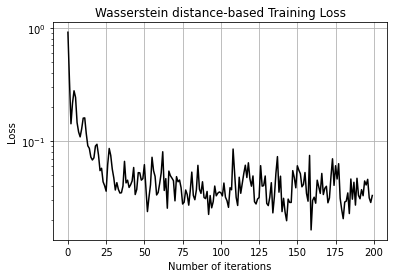

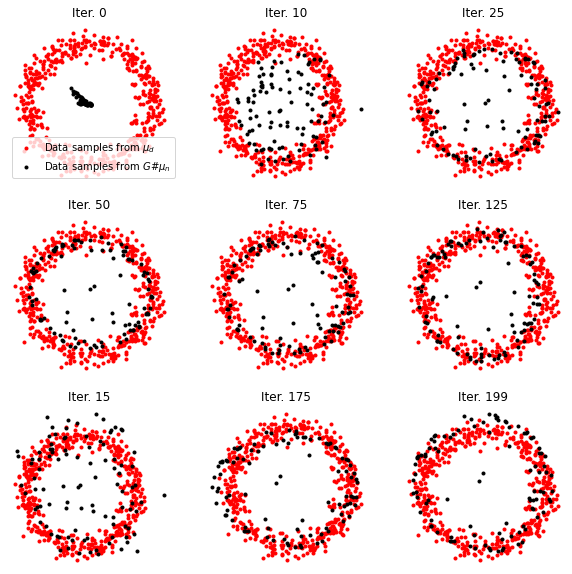

In [ ]:
# Plots
plot_losses(losses, 'black')
plot_trajectories(xd, xvisu, 'figures/WGAN_iterations.png')

## Approximated WGAN

In [ ]:
p = 500
losses, G, xvisu, xd = WGAN_approx(p)

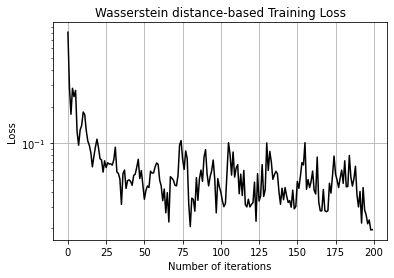

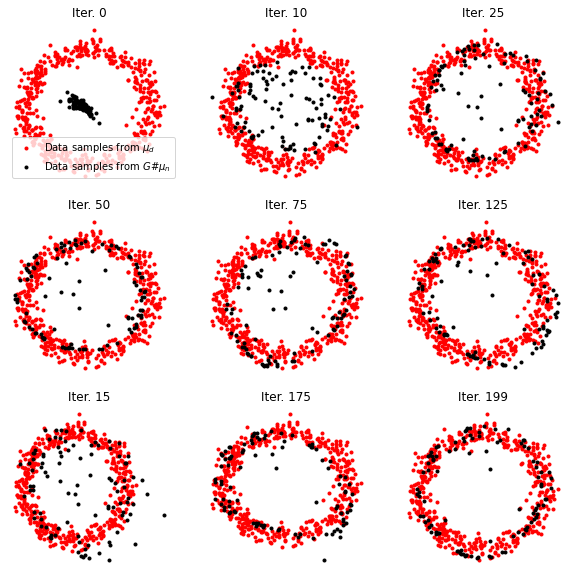

In [ ]:
# Plots
plot_losses(losses, 'black')
plot_trajectories(xd, xvisu, 'figures/WGAN_approx_iterations.png')

## Evaluation of the approximation when the number of reference points changes

In [ ]:
loss_p = []
WGANS = []
n_points = [0, 1, 5, 10, 50, 500]
for p in n_points:
  if p == 0:
    losses, G, _, _ = WGAN()
  else:
    losses, G, _, _ = WGAN_approx(p)
  loss_p.append(losses)
  WGANS.append(G)

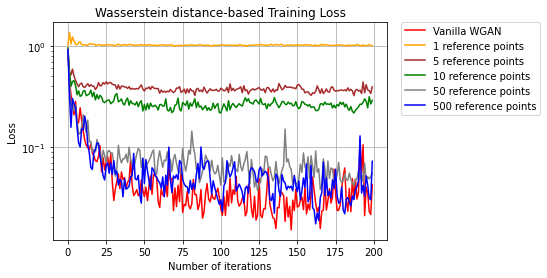

In [ ]:
colors = ['r', 'orange', 'brown', 'green', 'grey', 'blue']
pl.figure(1)
pl.grid()
pl.title('Wasserstein distance-based Training Loss')
for i,p in enumerate(n_points):
    losses = loss_p[i]
    if i == 0:
        pl.semilogy(losses, label='Vanilla WGAN', color=colors[i])
    else:
        pl.semilogy(losses, label='{} reference points'.format(p), color=colors[i])
    pl.xlabel("Number of iterations")
    pl.ylabel("Loss")
    pl.legend(loc='upper left', bbox_to_anchor=(1.025, 1.025))
pl.savefig('figures/WGAN_all_losses.png')
pl.show()

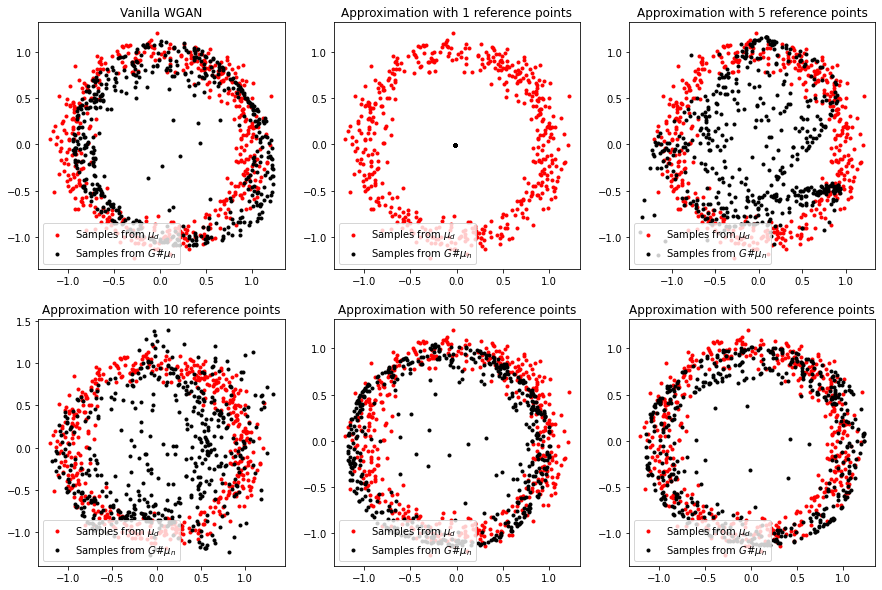

In [ ]:
size_batch = 500
xd = get_data(size_batch)
xn = get_random(size_batch) 
pl.figure(3, (15, 10))
for i,p in enumerate(n_points):
    pl.subplot(2, 3, i + 1)
    G = WGANS[i]
    x = G(xn).detach().numpy()
    pl.scatter(xd[:, 0], xd[:, 1], marker=marker, c='r', label='Samples from $\mu_d$')
    pl.scatter(x[:, 0], x[:, 1], marker=marker, c='black', label='Samples from $G\#\mu_n$')
    if p == 0:
        pl.title('Vanilla WGAN')
    else:
        pl.title('Approximation with {} reference points'.format(p))
    pl.legend(loc='lower left')
pl.savefig('figures/WGAN_all_comparisons.png')
pl.show()

## Comparison of Vanilla GAN and best approximation

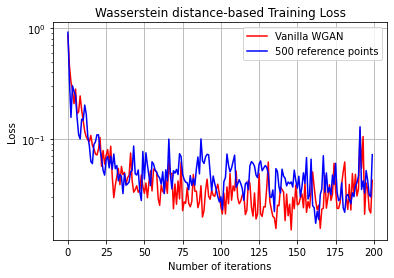

In [ ]:
pl.figure(1)
pl.grid()
pl.title('Wasserstein distance-based Training Loss')
selection = [(0,0),(-1,n_points[-1])]
for i,p in selection:
    losses = loss_p[i]
    if p == 0:
        pl.semilogy(losses, label='Vanilla WGAN', color='r')
    else:
        pl.semilogy(losses, label='{} reference points'.format(p), color='b')
    pl.grid()
    pl.xlabel("Number of iterations")
    pl.ylabel("Loss")
    pl.legend(loc='upper right')
pl.savefig('figures/WGAN_best_loss.png')
pl.show()

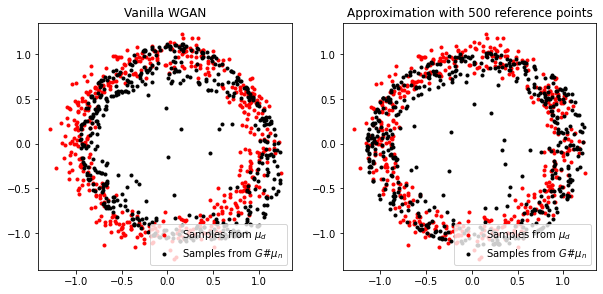

In [ ]:
size_batch = 500
xd = get_data(size_batch)
xn = get_random(size_batch) 
pl.figure(2, (10, 10))

pl.subplot(2,2,1)
G = WGANS[0]
x = G(xn).detach().numpy()
pl.scatter(xd[:, 0], xd[:, 1], marker=marker, c='r', label='Samples from $\mu_d$')
pl.scatter(x[:, 0], x[:, 1], marker=marker, c='black', label='Samples from $G\#\mu_n$')
pl.title('Vanilla WGAN')
pl.legend(loc='lower right')

pl.subplot(2,2,2)
G = WGANS[-1]
x = G(xn).detach().numpy()
pl.scatter(xd[:, 0], xd[:, 1], marker=marker, c='r', label='Samples from $\mu_d$')
pl.scatter(x[:, 0], x[:, 1], marker=marker, c='black', label='Samples from $G\#\mu_n$')
pl.title('Approximation with {} reference points'.format(n_points[-1]))
pl.legend(loc='lower right')
pl.savefig('figures/WGAN_best_comparison.png')
pl.show()

## We showed empirically that $W_2^z$ is a good proxy for $W_2$.
## We can see that a very low $p$ leads to a poor approximation and that from $p=50$, the approximation of the Wasserstein Distance is satisfying. The best approximation is reached for $p=500$. 

# 3. Logistic Classification using OTK embeddings 

We use the OTK implemented in [GregoireMialon/OTK](https://github.com/GregoireMialon/OTK/tree/9c414d800476df2ad84fcf8042e717eb992e3370) and some
code inspired from [sklearn_MNIST](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html).

## Utils functions

In [ ]:
# split in train and test sets
def split_data(X, y, train_size, test_size):
    random_state = check_random_state(0)
    permutation = random_state.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    X = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

# scale data
def scale(X_train, X_test):
    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test

# Classifier
def classifier(X_train, X_test, y_train, y_test, t0, sparse, verbose=True):
    # Turn up tolerance for faster convergence
    if sparse:
      penalty = "l1"
    else:
      penalty = "l2"
    train_samples = X_train.shape[0]
    clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
    clf.fit(X_train, y_train)
    sparsity = np.mean(clf.coef_ == 0) * 100
    score = clf.score(X_test, y_test)
    if verbose:
      print("Sparsity with {} penalty: {:.2f}".format(penalty,sparsity))
      print("Test score with {} penalty: {:.4f}".format(penalty,score))
      run_time = time.time() - t0
      print("Example run in %.3f s" % run_time)
    return clf, score, sparsity

## Go to repository path to use OTK module

In [ ]:
"""
# Uncomment to clone project https://github.com/GregoireMialon/OTK/tree/9c414d800476df2ad84fcf8042e717eb992e3370
!git clone https://github.com/GregoireMialon/OTK.git

# ************** Modification to do on ckn/layers.py --> **********
# Change:
# "from sklearn.linear_model.base import LinearModel, LinearClassifierMixin" to 
# "from sklearn.linear_model._base import LinearModel, LinearClassifierMixin"
"""

# Go in folder where this repository is
path_repo = "MVA/Courses/Optimal_Transport/Project/OTK"
os.chdir("/content/drive/MyDrive/"+path_repo)

Mounted at /content/drive/


## Generate and plot data

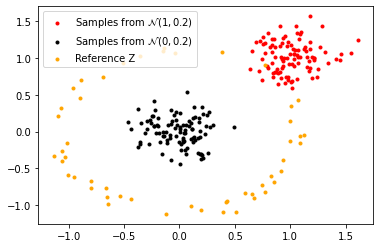

In [ ]:
def get_gauss(size, dim, mu, sigma=0.1):
    return mu + sigma * np.random.randn(size,dim) 

n = 100
p = 50
sigma = 0.2
X = get_gauss(n, 2, 1, sigma)
Y = get_gauss(n, 2,0, sigma)
Z = get_reference(p, 1) # function defined in section Wasserstein GAN

pl.figure(1)
pl.scatter(X[:, 0], X[:, 1], marker='.', c='r', label='Samples from $\mathcal{N}(1,0.2)$')
pl.scatter(Y[:, 0], Y[:, 1], marker='.', c='black', label='Samples from $\mathcal{N}(0,0.2)$')
pl.scatter(Z[:, 0], Z[:, 1], marker='.', c='orange', label='Reference Z')
pl.legend(loc='upper left')
pl.savefig('figures/Logistic_data_distribution.png')
pl.show()

## Create dataset with 2D-gaussians centered in 0 or 1 

In [ ]:
def get_dataset(n_data, dim, size, sigma):
  X = np.zeros((n_data, size, dim))
  y = np.zeros(n_data, dtype=int)
  for i in range(n_data):
    if i <= int(n_data/2):
      mu = 0
    else:
      mu = 1
    X[i] = get_gauss(size, dim, mu, sigma)
    y[i] = mu

  return X, y

n_data = 400
dim = 2
size = 100
sigma = 5
gauss_data, gauss_labels = get_dataset(n_data, dim, size, sigma)

## Classification without embeddings

In [ ]:
train_size = 200
test_size = 200
train_data, test_data, y_train, y_test = split_data(gauss_data, gauss_labels, train_size, test_size)
t0 = time.time()
X_train, X_test = scale(train_data, test_data)
sparse = True
clf, score, sparsity = classifier(X_train, X_test, y_train, y_test, t0, sparse)

Sparsity with l1 penalty: 2.50
Test score with l1 penalty: 0.8300
Example run in 0.023 s


## Classification of gaussian distributions with OTK embeddings

In [ ]:
## Create embedding
from otk.layers import OTKernel
in_dim = dim
out_size = 50
eps = sigma
Kernel = OTKernel(in_dim=in_dim, out_size=out_size, eps=eps, heads=1)

# Initialize kernel with reference weights
r = 1
z = get_reference(out_size, r) 
weight = torch.Tensor(z).unsqueeze(dim=0)
Kernel.random_sample(weight)

In [ ]:
t0 = time.time()
# Reshape in 2D gaussians to apply OTK embeddings
X_train_emb = train_data.reshape((train_size,size,dim))
X_test_emb = test_data.reshape((train_size,size,dim))

# embed and flatten embedded X_train, X_test
train_embed = Kernel(torch.Tensor(X_train_emb)).flatten(start_dim=1)
test_embed = Kernel(torch.Tensor(X_test_emb)).flatten(start_dim=1)
X_train_emb = train_embed.detach().numpy()
X_test_emb = test_embed.detach().numpy()

# Classify
X_train_emb, X_test_emb = scale(X_train_emb, X_test_emb)
sparse = True
clf, score, sparsity = classifier(X_train_emb, X_test_emb, y_train, y_test, t0, sparse)

Sparsity with l1 penalty: 0.00
Test score with l1 penalty: 0.9300
Example run in 0.372 s


## Compare T-SNE embedding of test data before and after OTK embedding

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# TSNE embeddings
xp = TSNE().fit_transform(X_test)
xp_emb = TSNE().fit_transform(X_test_emb)

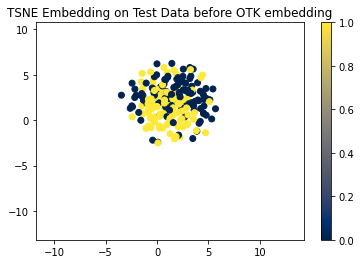

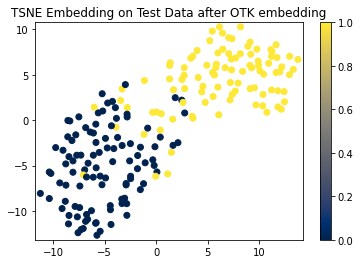

In [ ]:
# Without OTK embeddings
pl.figure(3)
cmap = 'cividis'
marker = 'o'
pl.scatter(xp[:,0], xp[:,1], c=y_test, marker=marker, cmap=cmap)
pl.colorbar()
pl.title('TSNE Embedding on Test Data before OTK embedding');
pl.xlim(np.min(xp_emb[:,0])-.5,np.max(xp_emb[:,0])+.5)
pl.ylim(np.min(xp_emb[:,1])-.5,np.max(xp_emb[:,1])+.5)
pl.show()

# With OTK embeddings
pl.figure(4)
pl.scatter(xp_emb[:,0], xp_emb[:,1], c=y_test, marker=marker, cmap=cmap)
pl.colorbar()
pl.title('TSNE Embedding on Test Data after OTK embedding');
pl.xlim(np.min(xp_emb[:,0])-.5,np.max(xp_emb[:,0])+.5)
pl.ylim(np.min(xp_emb[:,1])-.5,np.max(xp_emb[:,1])+.5)
pl.show()

## We can see that applying the OTK embedding proposed in [A Trainable Optimal Transport Embedding and its Relatishionship with Attention](https://openreview.net/pdf?id=ZK6vTvb84s) enables to better seperate the two classes. This is the reason why the classification results are better with this OT embedding. Even on a very simple classification problem, we see the advantage of using such an embedding for sequence and set data.

## Evaluate embeddings when sigma changes

In [ ]:
def comparison(n_data, dim, size, sigmas, percentage, sparse=True, verbose=True):

    clfs = []
    scores = []
    sparsities = [] 
    data = []
    labels = []

    # Initialize reference z
    p = 50
    r = 1
    z = get_reference(p, r) 
    weight = torch.Tensor(z).unsqueeze(dim=0)

    for sigma in sigmas:

        if verbose: 
            print('Sigma: {}\n'.format(sigma))
            print('Classification without embeddings')

        # Generate dataset and split data
        gauss_data, gauss_labels = get_dataset(n_data, dim, size, sigma)
        train_size = int(n_data * percentage)
        test_size = n_data - train_size
        train_data, test_data, y_train, y_test = split_data(gauss_data, gauss_labels, train_size, test_size)

        # Classification without embedding
        X_train, X_test = scale(train_data, test_data)
        t0 = time.time()
        clf, score, sparsity = classifier(X_train, X_test, y_train, y_test, t0, sparse, verbose)
        if verbose:
            print('-----------------------------\n')
            print('Classification with OTK embeddings')

        # Embed data
        in_dim = dim
        out_size = p
        eps = sigma
        Kernel = OTKernel(in_dim=in_dim, out_size=out_size, eps=eps, heads=1)

        # Initialize kernel with reference weights
        Kernel.random_sample(weight)

        # Reshape in 2D gaussians to apply OTK embeddings
        X_train_emb = train_data.reshape((train_size,size,dim))
        X_test_emb = test_data.reshape((test_size,size,dim))

        # embed and flatten embedded X_train, X_test
        train_embed = Kernel(torch.Tensor(X_train_emb)).flatten(start_dim=1)
        test_embed = Kernel(torch.Tensor(X_test_emb)).flatten(start_dim=1)
        X_train_emb = train_embed.detach().numpy()
        X_test_emb = test_embed.detach().numpy()

        # Classification with embeddings
        X_train_emb, X_test_emb = scale(X_train_emb, X_test_emb)
        t0 = time.time()
        clf_emb, score_emb, sparsity_emb = classifier(X_train_emb, X_test_emb, y_train, y_test, t0, sparse, verbose)

        # Updata clfs
        clfs.append((clf, clf_emb))
        scores.append((score, score_emb))
        sparsities.append((sparsity, sparsity_emb))
        data.append((X_test, X_test_emb))
        labels.append(y_test)
        if verbose:
            print('-----------------------------\n')

    return clfs, scores, sparsities, data, labels

In [ ]:
n_data = 400
dim = 2
size = 100
step = 100
sigmas = np.linspace(1,10, step) 
percentage = 0.5
sparse = True
verbose = False
clfs, scores, sparsities, data, labels = comparison(n_data, dim, size, sigmas, percentage, sparse=sparse, verbose=verbose)

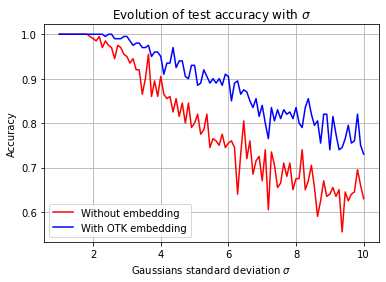

In [ ]:
# plot evolution of test accuracy
unzipped = list(zip(*scores))
ref, emb =  unzipped[0], unzipped[1]
pl.figure(1)
pl.grid()
pl.plot(sigmas, ref, color='r', label='Without embedding')
pl.plot(sigmas, emb, color='b', label='With OTK embedding')
pl.title('Evolution of test accuracy with $\sigma$')
pl.xlabel('Gaussians standard deviation $\sigma$')
pl.ylabel('Accuracy')
pl.legend(loc='lower left')
pl.savefig('figures/Logistic_accuracy_std.png')
pl.show()

## Compare T-SNE embedding of test data before and after OTK embedding

In [ ]:
# TSNE embeddings
unzipped = list(zip(*data))
ref, emb =  unzipped[0], unzipped[1]
indices = np.linspace(1, 99, 6)

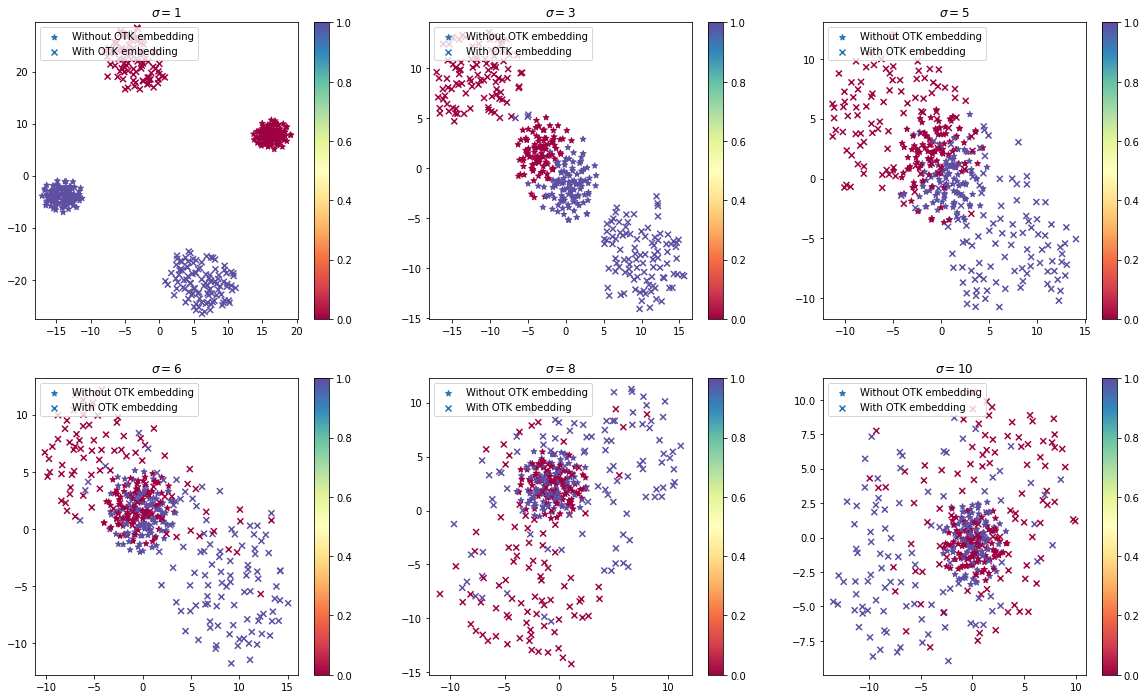

In [ ]:
import warnings
warnings.filterwarnings('ignore')

pl.figure(3, (20,12))
cmap = 'Spectral'
marker = 'o'
for i, index in enumerate(indices):
    index = int(index)
    sigma = sigmas[index]
    X_test = ref[index]
    X_test_emb = emb[index]
    y_test = labels[index]

    # TSNE embeddings
    xp = TSNE().fit_transform(X_test)
    xp_emb = TSNE().fit_transform(X_test_emb)

    # Plot
    pl.subplot(2,3,i+1)
    pl.scatter(xp[:,0], xp[:,1], c=y_test, marker='*', cmap=cmap, label='Without OTK embedding')
    pl.scatter(xp_emb[:,0], xp_emb[:,1], c=y_test, marker='x', cmap=cmap, label='With OTK embedding')
    sm = pl.cm.ScalarMappable(cmap=cmap)
    pl.colorbar(sm)
    pl.title('$\sigma = {}$'.format(round(sigma)))
    pl.legend(loc='upper left')
    x_axis_min = min(np.min(xp[:,0]),np.min(xp_emb[:,0]))
    x_axis_max = max(np.max(xp[:,0]),np.max(xp_emb[:,0]))
    y_axis_min = min(np.min(xp[:,1]),np.min(xp_emb[:,1]))
    y_axis_max = max(np.max(xp[:,1]),np.max(xp_emb[:,1]))
    marge = 1.0
    pl.xlim(x_axis_min-marge,x_axis_max+marge)
    pl.ylim(y_axis_min-marge,y_axis_max+marge)

pl.savefig('figures/Logistic_all_TSNE.png')
pl.show()

## We can see that the separation of classes is done better after the OTK embedding. 
## Moreover, when $\sigma$ increases, the data points are harder to classify as the gaussians have a higher standard deviation. We can see that with the OTK embedding, the seperation is more robust to the increase of $\sigma$.

# Conclusion
## 1. We retrieved the theoretical guarantees of the OTK embedding in terms of approximation of Wasserstein distance for 1D and 2D data samples.
## 2. We showed that the approximation error decreases when the number of points in reference increases.
## 3. We showed that the approximated Wasserstein Distance worked well when used as a loss in WGAN architectures, confirming that the approximation is good.
## 4. We showed that the approximation was better with more reference points and still reliable even with few reference points ($50$) compared to the number data points ($500$).
## 5. We showed that the OTK embeddings enabled better classification results than without embeddings.
## 6. We showed that the OTK embeddings enabled more robustness to increase of standard deviation of gaussian points in terms of class separation.